<img src="http://drive.google.com/uc?export=view&id=1tpOCamr9aWz817atPnyXus8w5gJ3mIts" width=500px>

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

### Package Version:
- tensorflow==2.2.0
- pandas==1.0.5
- numpy==1.18.5
- google==2.0.3

# Sarcasm Detection

### Dataset

#### Acknowledgement
Misra, Rishabh, and Prahal Arora. "Sarcasm Detection using Hybrid Neural Network." arXiv preprint arXiv:1908.07414 (2019).

**Required Files given in below link.**

https://drive.google.com/drive/folders/1xUnF35naPGU63xwRDVGc-DkZ3M8V5mMk

In [1]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline
# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D,TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

### Load Data (3 Marks)

# Mount the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#Change directory
import os;
os.chdir('/content/drive/My Drive/sarcasm detection/data/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading and Exploring Data

In [3]:
data_json = "Sarcasm_Headlines_Dataset.json"
import pandas as pd
data = pd.read_json(data_json,lines=True)

In [4]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [6]:
print('Analysis of `is_sarcastic` label by news website'); print('***'*30)

hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-sarcastic']))

Analysis of `is_sarcastic` label by news website
******************************************************************************************


,huffingtonpost,theonion
Sarcastic,0,11724
Non-sarcastic,14985,1


In [7]:
data['is_sarcastic'].value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

### Drop `article_link` from dataset (3 Marks)

In [8]:
data.drop('article_link', axis=1, inplace=True)
data.head()


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


### Get length of each headline and add a column for that (3 Marks)

* I added a new column named headline_count which tracks the length of the headline

In [9]:
data['headline_count'] = data.apply(lambda _: '', axis=1)
for i in range(data.shape[0]):
  data['headline_count'][i] = len(data['headline'][i].split())
data.head()

,headline,is_sarcastic,headline_count
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


In [10]:
print('The longest headline length is ',data['headline_count'].max())
print('The smallest headline length is ',data['headline_count'].min())

The longest headline length is  39
The smallest headline length is  2


# Cleaning the Data

In [11]:
preprocessed_reviews = []
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after','above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very','s', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"])

import re
from tqdm import tqdm
from bs4 import BeautifulSoup
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess_sentence(w):
    # w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.rstrip().strip()
    w = '<start> ' + w + ' <end>'
    return w

# tqdm is for printing the status bar
for sentance in tqdm(data['headline'].apply(str)):
    sentance = preprocess_sentence(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 26709/26709 [00:07<00:00, 3743.95it/s]


* I added a new column named cleaned_text_count which tracks the length of the cleaned headline

In [12]:
data['cleaned'] = data.apply(lambda _: '', axis=1)
data['cleaned_text_count'] = data.apply(lambda _: '', axis=1)
for i in range(26709):
  data['cleaned'][i] = preprocessed_reviews[i]
  data['cleaned_text_count'][i] = len(data['cleaned'][i].split())
data.head()

,headline,is_sarcastic,headline_count,cleaned,cleaned_text_count
0,former versace store clerk sues over secret 'b...,0,12,former versace store clerk sues secret black c...,10
1,the 'roseanne' revival catches up to our thorn...,0,14,roseanne revival catches thorny political mood...,8
2,mom starting to fear son's web series closest ...,1,14,mom starting fear son web series closest thing...,9
3,"boehner just wants wife to listen, not come up...",1,13,boehner wants wife listen not come alternative...,10
4,j.k. rowling wishes snape happy birthday in th...,0,11,j k rowling wishes snape happy birthday magica...,9


In [13]:
print('The longest headline (cleaned) length is ',data['cleaned_text_count'].max())
print('The smallest headline (cleaned) length is ',data['cleaned_text_count'].min())

The longest headline (cleaned) length is  30
The smallest headline (cleaned) length is  0


In [14]:
# reviews with zero text length after cleaning
data[data['cleaned_text_count']==0]

,headline,is_sarcastic,headline_count,cleaned,cleaned_text_count
999,who were you on 9/11?,0,5,,0
5322,"i was, but now i am",0,6,,0


Observation:
* This is because both of these are almost stopwords which i used

Word Cloud of Sarcastic Headlines


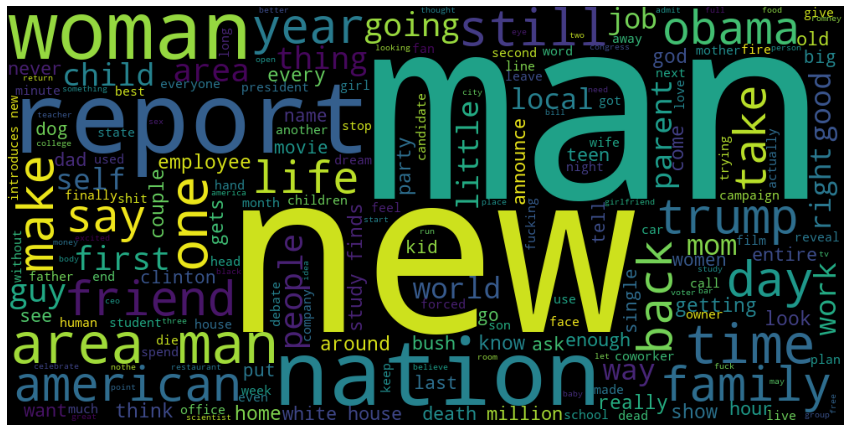

In [15]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

print('Word Cloud of Sarcastic Headlines')
data['headline'] = data['headline'].fillna('')
sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned'])
wordcloud = WordCloud(width = 1000, height = 500).generate(sarcastic_headlines)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

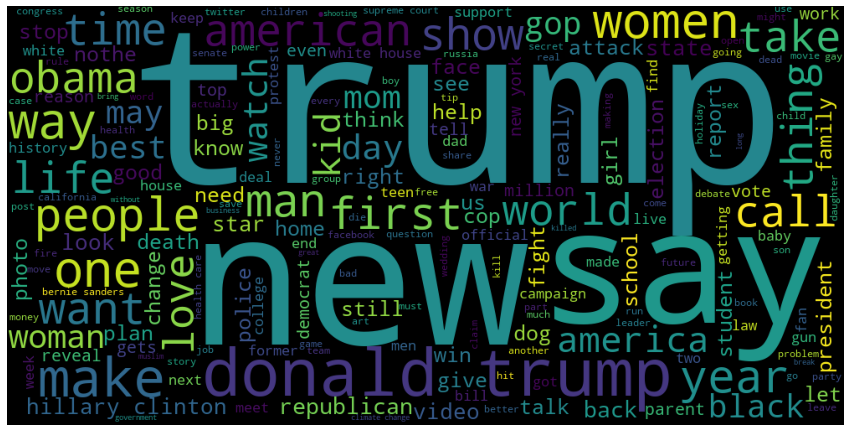

In [16]:
non_sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned'])
wordcloud = WordCloud(width = 1000, height = 500).generate(non_sarcastic_headlines)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
plt.close()

Observation:
* trump is a common word in both target groups, this is expected because he is the president of USA.

### 4) Initialize parameter values
- Set values for max_features, maxlen, & embedding_size
- max_features: Number of words to take from tokenizer(most frequent words)
- maxlen: Maximum length of each sentence to be limited to 25
- embedding_size: size of embedding vector

In [17]:
max_features = 10000
maxlen = 25
embedding_size = 300

* I used 10000 maximum features and 300 dimension Glove embeddings

### Apply `tensorflow.keras` Tokenizer and get indices for words (3 Marks)
- Initialize Tokenizer object with number of words as 10000
- Fit the tokenizer object on headline column
- Convert the text to sequence


In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned']))

### Pad sequences (3 Marks)
- Pad each example with a maximum length
- Convert target column into numpy array

In [19]:
X = tokenizer.texts_to_sequences(data['cleaned'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

### Vocab mapping
- There is no word for 0th index

In [20]:
print(tokenizer.word_index)

{'not': 1, 'trump': 2, 'new': 3, 'man': 4, 'one': 5, 'report': 6, 'area': 7, 'woman': 8, 'donald': 9, 'u': 10, 'says': 11, 'day': 12, 'first': 13, 'time': 14, 'obama': 15, 'no': 16, 'like': 17, 'women': 18, 'people': 19, 'get': 20, 'world': 21, 'life': 22, 'nation': 23, 'house': 24, 'clinton': 25, 'still': 26, 'white': 27, 'back': 28, 'make': 29, 'would': 30, 'could': 31, 'family': 32, 'americans': 33, 'black': 34, 'way': 35, 'year': 36, 'gop': 37, 'school': 38, 'american': 39, 'study': 40, 'years': 41, 'best': 42, 'bill': 43, 'president': 44, 'show': 45, 'america': 46, 'police': 47, 'watch': 48, 'really': 49, 'last': 50, 'home': 51, 'know': 52, 'state': 53, 'death': 54, 'good': 55, 'mom': 56, 'things': 57, 'video': 58, 'finds': 59, 'hillary': 60, 'going': 61, 'love': 62, 'health': 63, 'say': 64, 'big': 65, 'parents': 66, 'may': 67, 'nothe': 68, 'party': 69, 'campaign': 70, 'right': 71, 'every': 72, 'child': 73, 'need': 74, 'kids': 75, 'gets': 76, 'work': 77, 'getting': 78, 'little': 7

### Set number of words
- Since the above 0th index doesn't have a word, add 1 to the length of the vocabulary

In [21]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

25180


### Load Glove Word Embeddings (3 Marks)

In [22]:
#Extract Glove embedding zip file
glove_file = 'glove.6B.zip'
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

### Create embedding matrix

In [23]:
EMBEDDING_FILE = 'glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 300))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

### Define model (5 Marks)
- Hint: Use Sequential model instance and then add Embedding layer, Bidirectional(LSTM) layer, flatten it, then dense and dropout layers as required. 
In the end add a final dense layer with sigmoid activation for binary classification.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print(f'\nNumber of rows in training dataset: {X_train.shape[0]}')
print(f'Number of columns in training dataset: {X_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(X_train)))}')
print('*'*50)
print(f'\nNumber of rows in test dataset: {X_test.shape[0]}')
print(f'Number of columns in test dataset: {X_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(X_test)))}')


Number of rows in training dataset: 21367
Number of columns in training dataset: 25
Number of unique words in training dataset: 9989
**************************************************

Number of rows in test dataset: 5342
Number of columns in test dataset: 25
Number of unique words in test dataset: 7661


In [25]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
# model.add(GlobalMaxPool1D())
model.add(Flatten())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 300)           7554000   
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           439296    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               819328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

### Compile the model (3 Marks)

In [26]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

### Fit the model (4 Marks)

In [27]:
# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)  
mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.01, patience = 5),
callbacks = [es, mc, lr_r]
history = model.fit(X_train, y_train, batch_size=96, epochs=5, verbose=1,validation_split=0.2, callbacks = callbacks)

Epoch 1/5
178/179 [============================>.] - ETA: 0s - loss: 0.5627 - accuracy: 0.7082
Epoch 00001: val_loss improved from inf to 0.48962, saving model to sarcasm_detector.h5
179/179 [==============================] - 47s 261ms/step - loss: 0.5626 - accuracy: 0.7083 - val_loss: 0.4896 - val_accuracy: 0.7590
Epoch 2/5
178/179 [============================>.] - ETA: 0s - loss: 0.4699 - accuracy: 0.7800
Epoch 00002: val_loss improved from 0.48962 to 0.44867, saving model to sarcasm_detector.h5
179/179 [==============================] - 46s 255ms/step - loss: 0.4699 - accuracy: 0.7800 - val_loss: 0.4487 - val_accuracy: 0.7932
Epoch 3/5
178/179 [============================>.] - ETA: 0s - loss: 0.4053 - accuracy: 0.8146
Epoch 00003: val_loss improved from 0.44867 to 0.44712, saving model to sarcasm_detector.h5
179/179 [==============================] - 47s 260ms/step - loss: 0.4052 - accuracy: 0.8146 - val_loss: 0.4471 - val_accuracy: 0.7869
Epoch 4/5
178/179 [======================

Observations:
* This model will overfit if it is trained for more than 4 epochs.

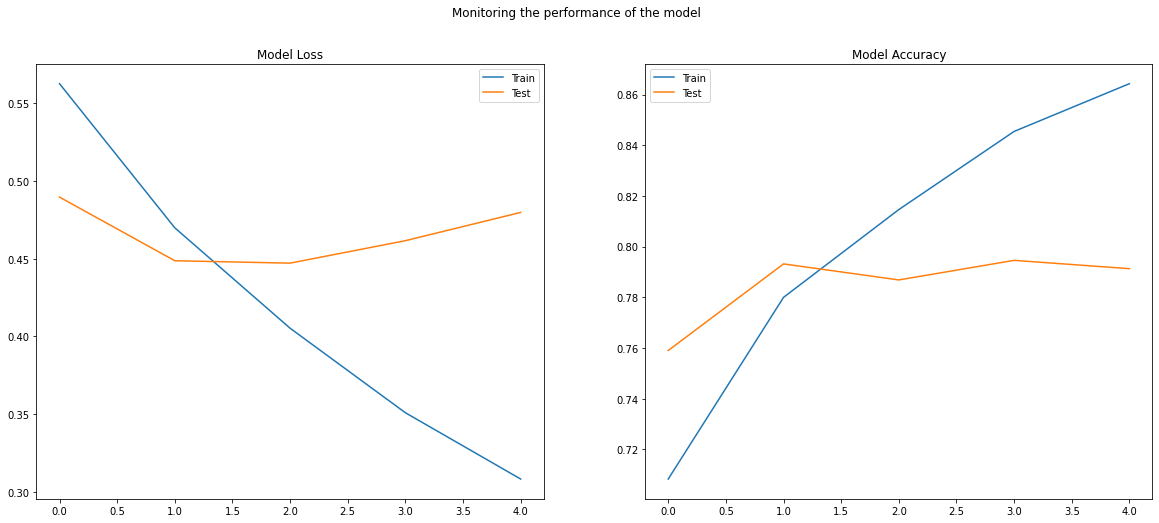

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 8))
f.suptitle('Monitoring the performance of the model')

ax1.plot(history.history['loss'], label = 'Train')
ax1.plot(history.history['val_loss'], label = 'Test')
ax1.set_title('Model Loss')
ax1.legend(['Train', 'Test'])

ax2.plot(history.history['accuracy'], label = 'Train')
ax2.plot(history.history['val_accuracy'], label = 'Test')
ax2.set_title('Model Accuracy')
ax2.legend(['Train', 'Test'])

plt.show()

In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose = 0)
print('loss: ', loss)
print('accuracy: ', accuracy)

loss:  0.4648738205432892
accuracy:  0.8053163886070251


In [30]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_curve
# Generic method to plot the VALIDATION curves
def plot_validation_curve(history, metrics):
    plt.clf()
    history_dict = history.history
    f, ax = plt.subplots(1, len(metrics), figsize=(16,6))
    for i, metric in enumerate(metrics):
        metric_values = history_dict[metric]
        val_metric_values = history_dict['val_' + metric]
        epochs = range(1, (len(history_dict[metric]) + 1))
        ax[i].plot(epochs, metric_values, 'bo:', label='Training ' + metric)
        ax[i].plot(epochs, val_metric_values, 'go-', label='Validation ' + metric)
        ax[i].set_title('Training and Validation ' + ('Accuracy' if metric=='accuracy' else 'Loss'))
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Accuracy' if metric=='acc' else 'Loss')
        ax[i].legend()
# Generic method to plot Precision-Recall curve
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

# Generic method to print the classification report
def classification_summary(y_test, y_pred, y_proba):
    print('\033[1mTesting accuracy:\033[0m %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('_'*80)
    print('\033[1mConfusion matrix:\033[0m\n %s' % (confusion_matrix(y_test, y_pred)))
    print('_'*80)
    print('\033[1mClassification report:\033[0m\n %s' % (classification_report(y_test, y_pred)))
    print('_'*80)
    print('\033[1mPrecision-Recall curve\033[10m')
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    plot_prec_recall_vs_thresh(precision, recall, thresholds)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Instructions for updating:
Please use `model.predict()` instead.
Testing accuracy: 80.53%
________________________________________________________________________________
Confusion matrix:
 [[2725  271]
 [ 769 1577]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84      2996
           1       0.85      0.67      0.75      2346

    accuracy                           0.81      5342
   macro avg       0.82      0.79      0.80      5342
weighted avg       0.81      0.81      0.80      5342

_________________

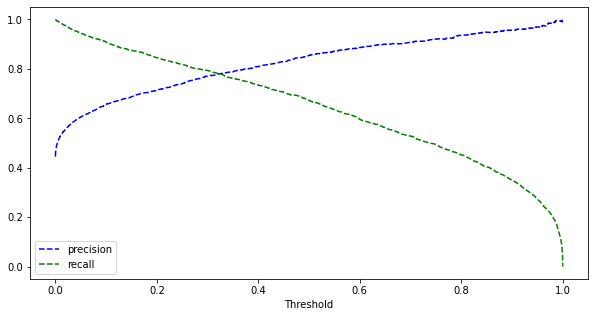

In [31]:
y_pred = model.predict_classes(X_test)
y_proba = model.predict_proba(X_test)
classification_summary(y_test, y_pred, y_proba)

### Trying model with custom data

In [34]:
statements = ['If you find me offensive. Then I suggest you quit finding me.', #Sarcastic
              'If I wanted to kill myself I would climb your ego and jump to your IQ.', #Sarcastic
              'i am good', #non sarcastic
              'Cows lose their jobs as milk prices drop' #sarcastic
              ]

for sentance in statements:
  sentance = preprocess_sentence(sentance)
  sentance = re.sub(r"http\S+", "", sentance)
  sentance = BeautifulSoup(sentance, 'html').get_text()
  sentance = decontracted(sentance)
  sentance = re.sub("\S*\d\S*", "", sentance).strip()
  sentance = re.sub('[^A-Za-z]+', ' ', sentance)

  headline = tokenizer.texts_to_sequences(sentance)
  headline = pad_sequences(headline, maxlen = maxlen, dtype = 'int32', value = 0)

  sentiment = (model.predict(headline)>0.5).astype('int32')
  if(np.argmax(sentiment) == 0):
      print(f'`{sentance}` is a Non-sarcastic statement.')
  elif (np.argmax(sentiment) == 1):
      print(f'`{sentance}` is a Sarcastic statement.')

`If you find me offensive Then I suggest you quit finding me ` is a Sarcastic statement.
`If I wanted to kill myself I would climb your ego and jump to your IQ ` is a Sarcastic statement.
`i am good` is a Non-sarcastic statement.
`Cows lose their jobs as milk prices drop` is a Non-sarcastic statement.


Conclusions:
* Loaded the data, done some EDA and visualisation with the help of Wordclouds.
* Cleaned the data, maximum number of tokens used are 10000 and 300 dimensions GLOVE embeddings were used.
* Created the bidirectional LSTM, and got 80% test accuracy.
* Also, tested with custom data and got good results.
